# Importing TensorFlow

In [1]:
!nvidia-smi

Tue Jun 18 03:48:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P4             18W /  100W |      17MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
print(tf.__version__)

2024-06-18 03:48:41.825391: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 03:48:41.846883: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 03:48:41.846900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 03:48:41.847466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 03:48:41.851275: I tensorflow/core/platform/cpu_feature_guar

2.15.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras
import os
import zipfile

# Preparing data

In [4]:
#!wget https://storage.googleapis.com/learning-datasets/horse-or-human.zip

In [5]:
#!wget https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip

In [6]:
#zip_ref = zipfile.ZipFile('./horse-or-human.zip', 'r')
#zip_ref.extractall('tmp/horse-or-human')

In [7]:
#zip_ref = zipfile.ZipFile('./validation-horse-or-human.zip', 'r')
#zip_ref.extractall('tmp/validation-horse-or-human')

In [8]:
#zip_ref.close()

In [9]:
train_horse_dir = os.path.join('tmp/horse-or-human/horses')
train_human_dir = os.path.join('tmp/horse-or-human/humans')
validation_horse_dir = os.path.join('tmp/validation-horse-or-human/horses')
validation_human_dir = os.path.join('tmp/validation-horse-or-human/humans')

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

val_datagen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "tmp/horse-or-human/",
    target_size=(300, 300),
    batch_size=32,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    "tmp/validation-horse-or-human",
    target_size=(300, 300),
    batch_size=32,
    class_mode="binary"
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [11]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoint/cp.ckpt",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

In [12]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


# Creating models

## DNN model

In [13]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[300,300,3]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

2024-06-18 03:48:43.468071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6070 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [14]:
dnn_model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [15]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 270000)            0         
                                                                 
 dense (Dense)               (None, 1024)              276481024 
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 276743681 (1.03 GB)
Trainable params: 276743681 (1.03 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


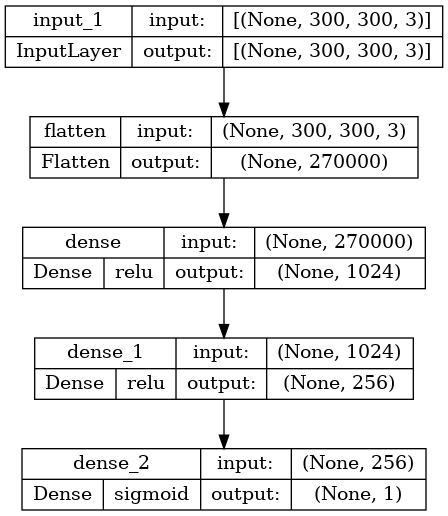

In [16]:
tf.keras.utils.plot_model(dnn_model, show_shapes=True, show_layer_activations=True)

In [17]:
visualkeras.layered_view(dnn_model)

## CNN model 0

In [18]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[300,300,3]),
    tf.keras.layers.Conv2D(16, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(32, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(64, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [19]:
cnn_model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [20]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 36, 36, 64)       

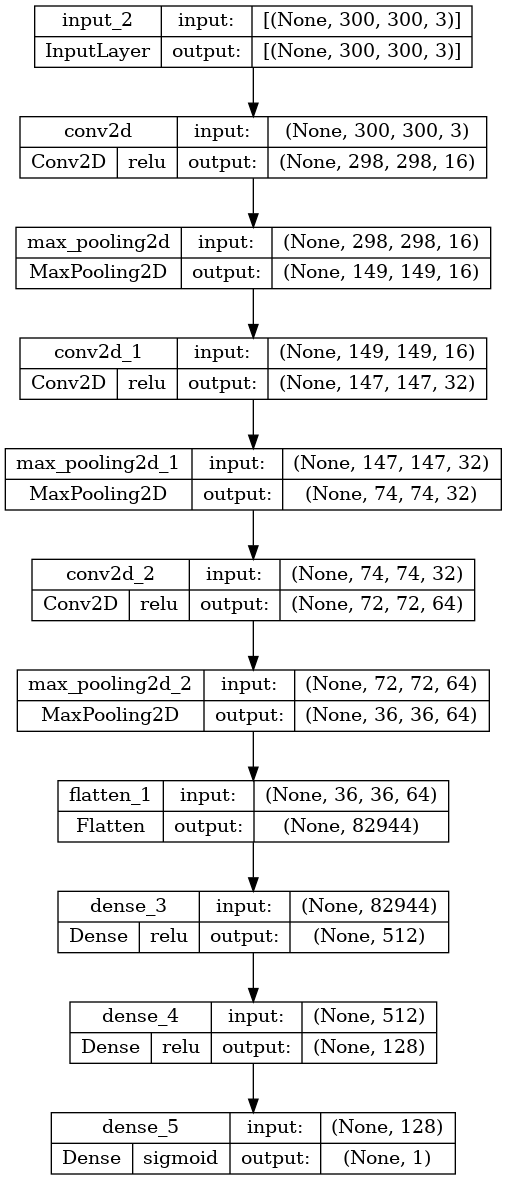

In [21]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True, show_layer_activations=True)

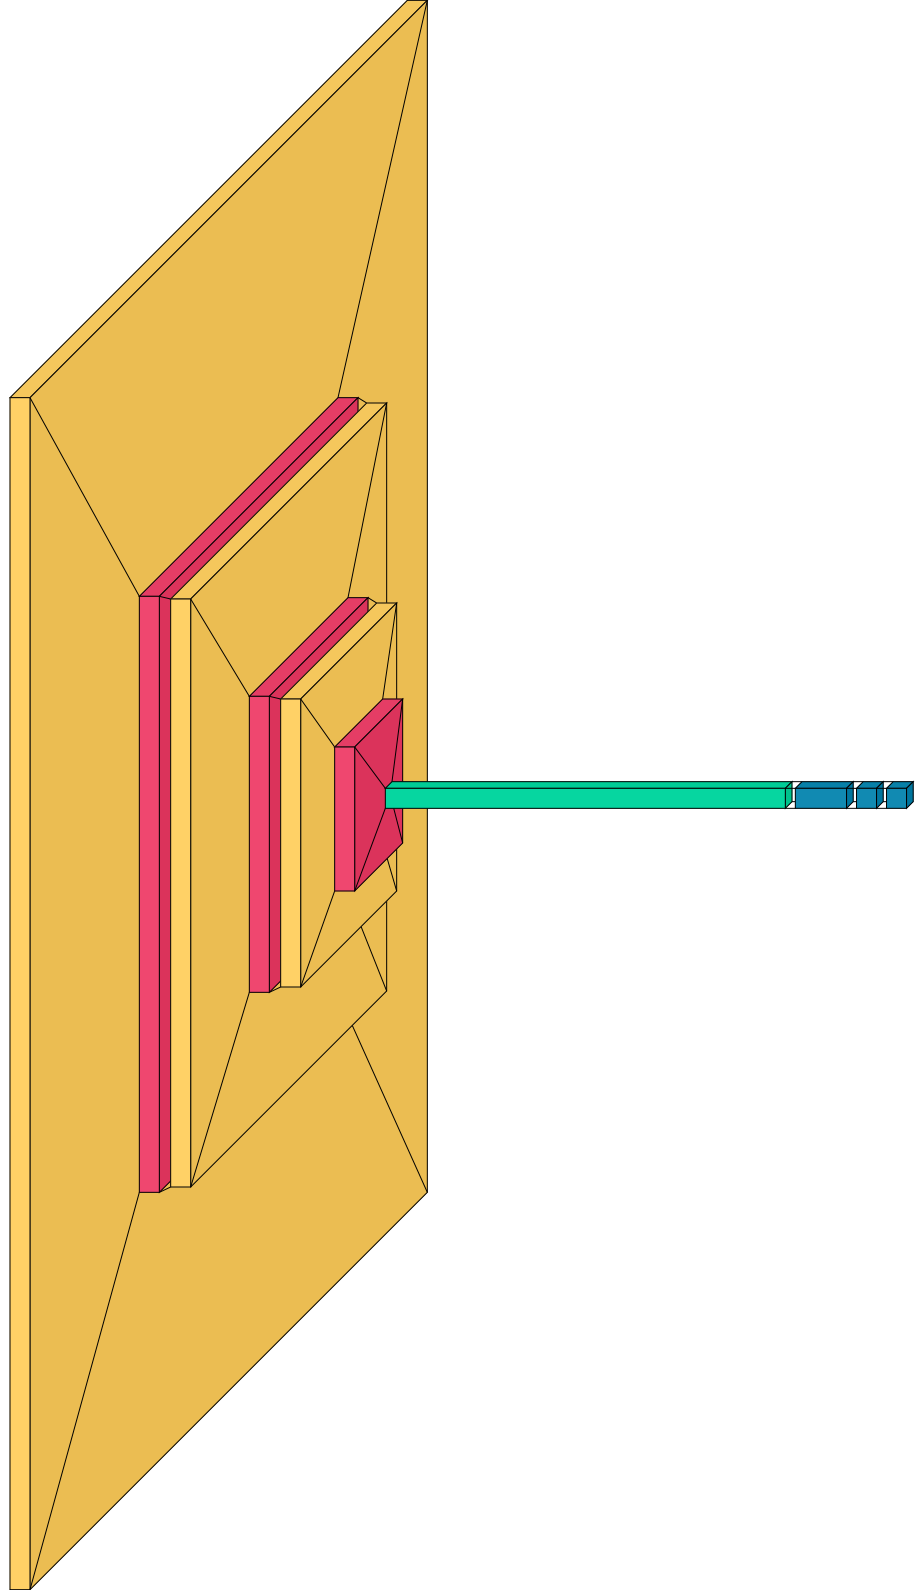

In [22]:
visualkeras.layered_view(cnn_model)

## CNN model 1

In [23]:
improved_cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[300,300,3]),
    tf.keras.layers.Conv2D(16, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2, 2, padding="same"),
    tf.keras.layers.Conv2D(32, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2, 2, padding="same"),
    tf.keras.layers.Conv2D(64, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2, 2, padding="same"),
    tf.keras.layers.Conv2D(128, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2, 2, padding="same"),
    tf.keras.layers.Conv2D(256, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2, 2, padding="same"),
    tf.keras.layers.Conv2D(512, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2, 2, padding="same"),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [24]:
improved_cnn_model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [25]:
improved_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 149, 149, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)       

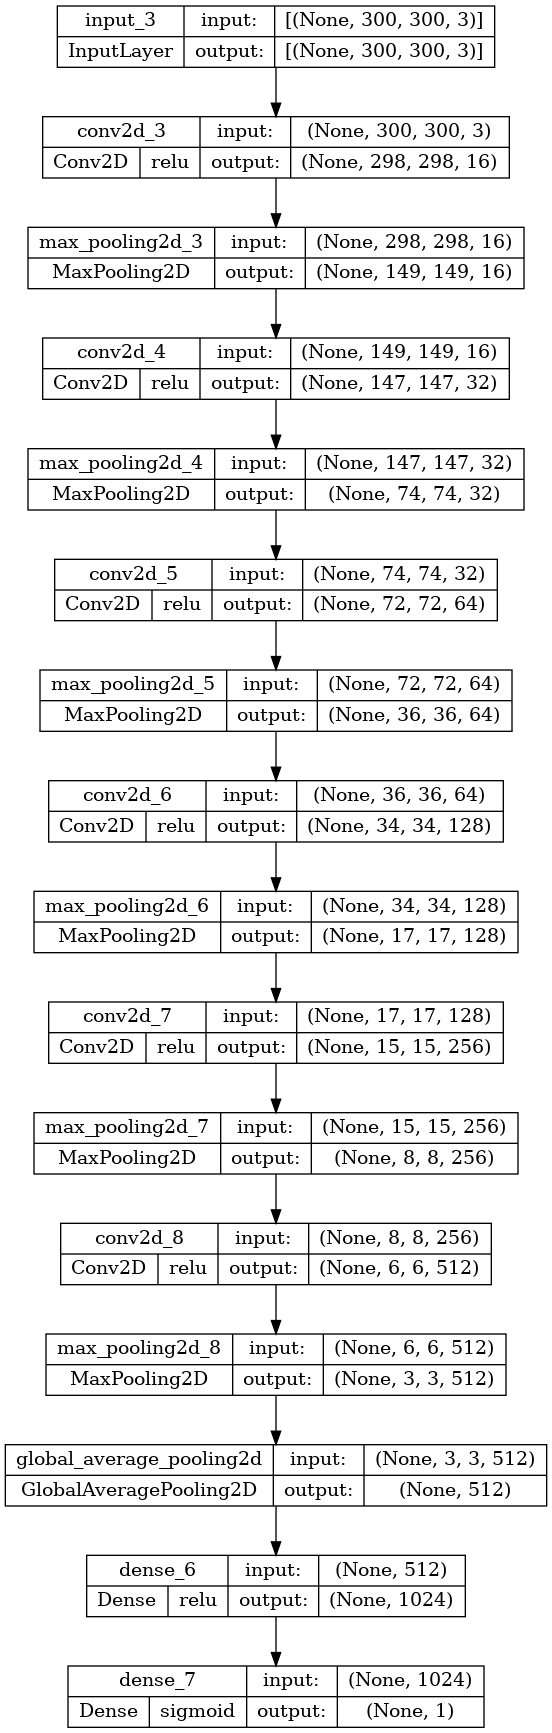

In [26]:
tf.keras.utils.plot_model(improved_cnn_model, show_shapes=True, show_layer_activations=True)

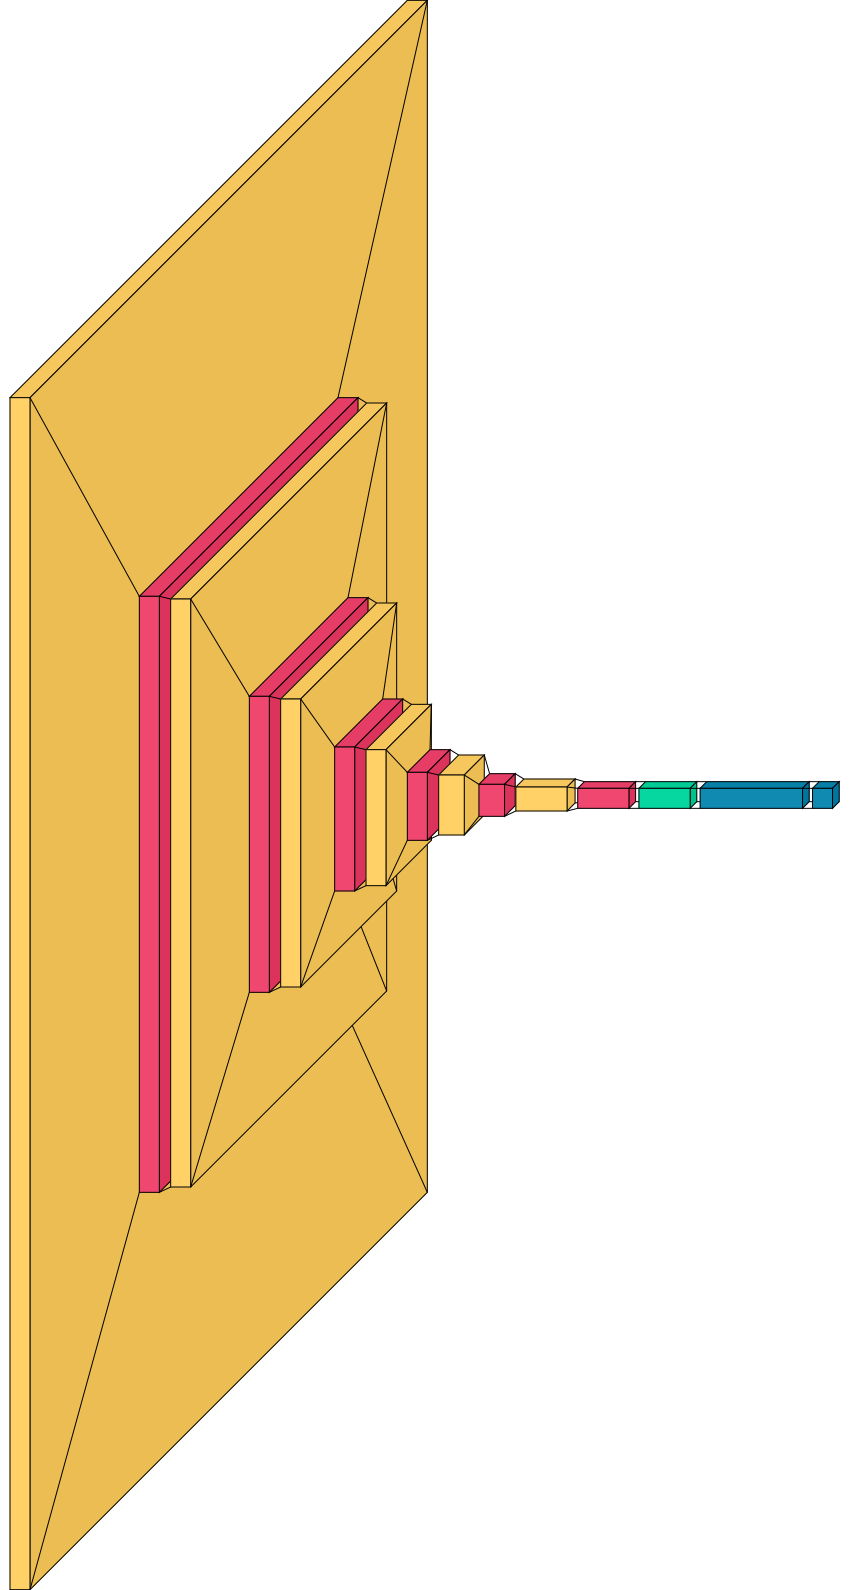

In [27]:
visualkeras.layered_view(improved_cnn_model)

## EfficientNet model

In [28]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=[300,300,3])
x = tf.keras.layers.Rescaling(255.)(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation="relu")(x)

non_trainable_efficientnet_model = tf.keras.models.Model(inputs, outputs)

In [29]:
non_trainable_efficientnet_model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [30]:
non_trainable_efficientnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional  (None, None, None, 1536   10783535  
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 10785072 (41.14 MB)
Trainable params: 1537 (6.0

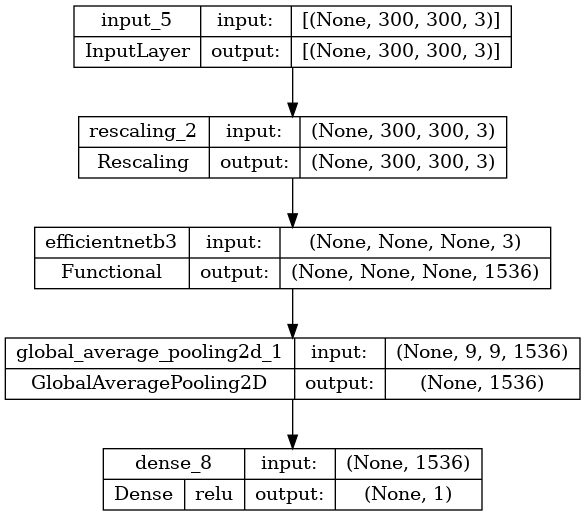

In [31]:
tf.keras.utils.plot_model(non_trainable_efficientnet_model, show_shapes=True, show_layer_activations=True)

# Training models

## DNN model

In [33]:
dnn_history = dnn_model.fit(
    x = train_generator,
    validation_data = val_generator,
    epochs = 10,
    callbacks = model_checkpoint
)

Epoch 1/10
33/33 [==============================] - 16s 476ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/10
33/33 [==============================] - 11s 344ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/10
33/33 [==============================] - 11s 346ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/10
33/33 [==============================] - 12s 347ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/10
33/33 [==============================] - 12s 353ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/10
33/33 [==============================] - 12s 357ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/10
33/33 [==============================] - 12s 353ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5000
Epoch 8/10
33/33 [=======================

<Axes: >

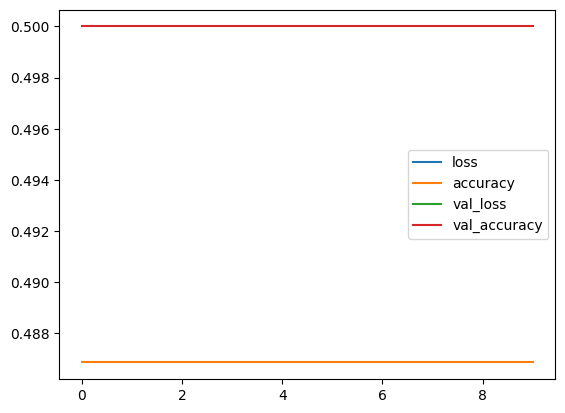

In [34]:
pd.DataFrame(dnn_history.history).plot()

## CNN model 0

In [35]:
cnn_history = cnn_model.fit(
    x = train_generator,
    validation_data = val_generator,
    epochs = 10,
    callbacks = model_checkpoint
)

Epoch 1/10


2024-06-18 03:53:39.756839: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


33/33 [==============================] - 14s 332ms/step - loss: 1.4511 - accuracy: 0.5940 - val_loss: 1.1126 - val_accuracy: 0.5000
Epoch 2/10
33/33 [==============================] - 12s 371ms/step - loss: 0.4659 - accuracy: 0.7760 - val_loss: 2.2764 - val_accuracy: 0.5586
Epoch 3/10
33/33 [==============================] - 12s 349ms/step - loss: 0.3415 - accuracy: 0.8442 - val_loss: 6.1265 - val_accuracy: 0.5078
Epoch 4/10
33/33 [==============================] - 12s 348ms/step - loss: 0.2658 - accuracy: 0.8958 - val_loss: 5.4946 - val_accuracy: 0.5195
Epoch 5/10
33/33 [==============================] - 12s 349ms/step - loss: 0.2314 - accuracy: 0.9056 - val_loss: 7.1597 - val_accuracy: 0.5195
Epoch 6/10
33/33 [==============================] - 12s 362ms/step - loss: 0.2044 - accuracy: 0.9172 - val_loss: 4.9978 - val_accuracy: 0.5156
Epoch 7/10
33/33 [==============================] - 12s 355ms/step - loss: 0.1708 - accuracy: 0.9289 - val_loss: 6.8921 - val_accuracy: 0.5117
Epoch 8/10

<Axes: >

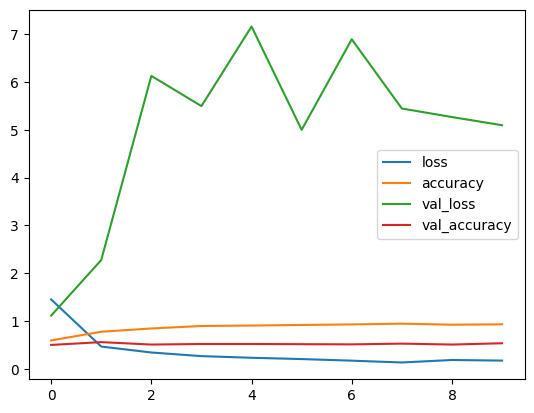

In [36]:
pd.DataFrame(cnn_history.history).plot()

## CNN model 1

In [37]:
improved_cnn_history = improved_cnn_model.fit(
    x = train_generator,
    validation_data = val_generator,
    epochs = 10,
    callbacks = model_checkpoint
)

Epoch 1/10
33/33 [==============================] - 14s 334ms/step - loss: 0.6933 - accuracy: 0.4927 - val_loss: 0.7051 - val_accuracy: 0.5000
Epoch 2/10
33/33 [==============================] - 12s 356ms/step - loss: 0.6304 - accuracy: 0.5842 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 3/10
33/33 [==============================] - 12s 360ms/step - loss: 0.6702 - accuracy: 0.5375 - val_loss: 0.8445 - val_accuracy: 0.5000
Epoch 4/10
33/33 [==============================] - 12s 365ms/step - loss: 0.6712 - accuracy: 0.5833 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 5/10
33/33 [==============================] - 12s 369ms/step - loss: 0.6740 - accuracy: 0.5278 - val_loss: 0.6239 - val_accuracy: 0.5977
Epoch 6/10
33/33 [==============================] - 12s 363ms/step - loss: 0.7105 - accuracy: 0.5375 - val_loss: 0.6870 - val_accuracy: 0.5000
Epoch 7/10
33/33 [==============================] - 12s 362ms/step - loss: 0.6727 - accuracy: 0.5287 - val_loss: 0.6689 - val_accuracy: 0.5000

<Axes: >

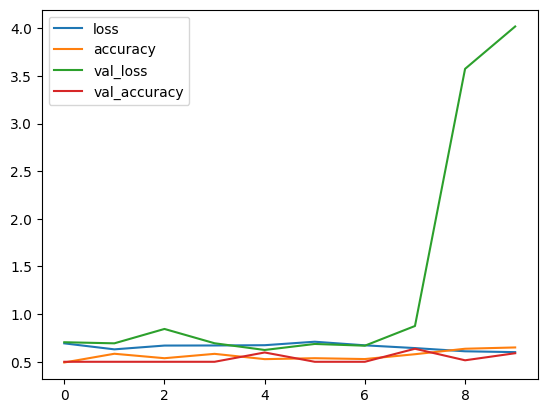

In [38]:
pd.DataFrame(improved_cnn_history.history).plot()

## EffientNet model

In [44]:
non_trainable_efficientnet_history = non_trainable_efficientnet_model.fit(
    x = train_generator,
    validation_data = val_generator,
    epochs = 3,
    callbacks = model_checkpoint
)

Epoch 1/3
33/33 [==============================] - 12s 373ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9961
Epoch 2/3
33/33 [==============================] - 12s 370ms/step - loss: 3.0827e-04 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9961
Epoch 3/3
33/33 [==============================] - 12s 370ms/step - loss: 7.1216e-04 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9961


<Axes: >

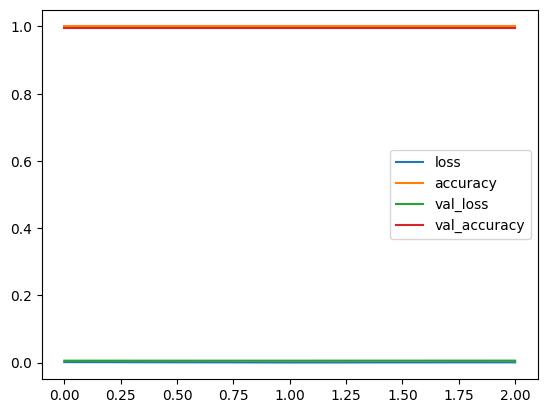

In [45]:
pd.DataFrame(non_trainable_efficientnet_history.history).plot()

# Model comp.

In [47]:
print("dnn_model:")
dnn_model_eval = dnn_model.evaluate(val_generator)
print("\ncnn_model")
cnn_model_eval = cnn_model.evaluate(val_generator)
print("\nimproved_cnn_model")
improved_cnn_model_eval = improved_cnn_model.evaluate(val_generator)
print("\nnon_trainable_efficientnet_model")
non_trainable_efficientnet_model_eval = non_trainable_efficientnet_model.evaluate(val_generator)

dnn_model:
8/8 [==============================] - 1s 60ms/step - loss: nan - accuracy: 0.5000

cnn_model
8/8 [==============================] - 1s 59ms/step - loss: 5.0950 - accuracy: 0.5352

improved_cnn_model
8/8 [==============================] - 1s 60ms/step - loss: 4.0193 - accuracy: 0.5898

non_trainable_efficientnet_model
8/8 [==============================] - 1s 74ms/step - loss: 0.0058 - accuracy: 0.9961


# Summary

DNN model and CNN models did not perform well in this classification task.

EfficientNetB3 model performed nearly 100% accurate for both train and validation data.